In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import matplotlib.gridspec as gridspec
import ast
import sys
sys.path.append('machine-scientist/')
sys.path.append('machine-scientist/Prior/')
from mcmc import *
from parallel import *
from fit_prior import read_prior_par
from sklearn.metrics import mean_squared_error
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error

In [2]:
def clean_index(dataframe):
    dataframe.set_index('Unnamed: 0', inplace=True)
    dataframe.index.name = None
    dataframe= dataframe.reset_index(drop=True)
    return dataframe

def add_bms_pred(dataframe, bms_trace, number_param):
    VARS = ['x1',]
    x = dn[[c for c in VARS]].copy()
    y=dataframe.noise

    if number_param==10:
        prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np10.2017-10-18 18:07:35.089658.dat')
    elif number_param==20:
        prior_par = read_prior_par('machine-scientist/Prior/final_prior_param_sq.named_equations.nv1.np20.maxs200.2024-05-10 162907.551306.dat')

    #mdl model
    minrow = bms_trace[bms_trace.H == min(bms_trace.H)].iloc[0]
    minH, minexpr, minparvals = minrow.H, minrow.expr, ast.literal_eval(minrow.parvals)

    t = Tree(
        variables=list(x.columns),
        parameters=['a%d' % i for i in range(number_param)],
        x=x, y=y,
        prior_par=prior_par,
        max_size=200,
        from_string=minexpr,
    )

    t.set_par_values(deepcopy(minparvals))

    dplot = deepcopy(dn)
    dplot['ybms'] = t.predict(x)

    return dplot
    

In [3]:
#Read NN and BMS data
function='tanh' #tanh, leaky_ReLU
realizations=2
N=9
#sigmas=[sigma_y for sigma_y in np.arange(0,0.2,0.02)]
sigmas=[0.0, 0.02, 0.04,0.06, 0.08, 0.10, 0.12, 0.14, 0.16, 0.18, 0.20]


runid=0
NPAR=10 #10, 20
steps=50000
train_size=60

rmse_nn_train=[];rmse_nn_test=[]
rmse_mdl_train=[];rmse_mdl_test=[]

mae_nn_train=[];mae_nn_test=[]
mae_mdl_train=[];mae_mdl_test=[]

n_index=[];r_index=[];sigma_index=[]

#Put mae and rmse of each simulation (on nn and bms) in a dataframe
for sigma in sigmas:
    for r in range(realizations+1):
        #Read NN data
        if sigma==0.1:
            file_model='NN_no_overfit_' + function + '_sigma_' + '0.10' + '_r_' + str(r) + '.csv'
        else:
            file_model='NN_no_overfit_' + function + '_sigma_' + str(sigma) + '_r_' + str(r) + '.csv'
            
        model_d='../data/trained_nns/' + file_model
        d=pd.read_csv(model_d)

        for n in range(N+1):
            print("sigma")
            print(sigma)
            print(n)
            print(r)
            n_index.append(n);r_index.append(r);sigma_index.append(sigma)
            
            dn=d[d['rep']==n]
            dn=clean_index(dn)

            #Read BMS data
            if sigma==0.1:
                filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+'0.10'+ '_r_' + str(r) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
            else:
                filename='BMS_'+function+'_n_'+str(n)+'_sigma_'+str(sigma)+ '_r_' + str(r) + '_trace_'+str(steps)+'_prior_'+str(NPAR)+ '.csv'
        
            trace=pd.read_csv('../data/MSTraces/' + filename, sep=';', header=None, names=['t', 'H', 'expr', 'parvals', 'kk1', 'kk2','kk3'])
            dplot=add_bms_pred(dn, trace, NPAR)

            #Errors
            
            #nns
            rmse_nn_train_i=root_mean_squared_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
            rmse_nn_train.append(rmse_nn_train_i)
            
            rmse_nn_test_i=root_mean_squared_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])
            rmse_nn_test.append(rmse_nn_test_i)

            mae_nn_train_i=mean_absolute_error(dplot.loc[:train_size-1]['ymodel'],dplot.loc[:train_size -1]['y'])
            mae_nn_train.append(mae_nn_train_i)
            
            mae_nn_test_i=mean_absolute_error(dplot.loc[train_size-1:]['ymodel'],dplot.loc[train_size -1:]['y'])
            mae_nn_test.append(mae_nn_test_i)

            #bms
            try:
                rmse_mdl_i=mean_squared_error(dplot.ybms,dn.y)
            except ValueError:
                print("holis!")
                rmse_mdl_i=np.inf
            
            rmse_mdl_train_i=root_mean_squared_error(dplot.loc[:train_size-1]['ybms'],dn.loc[:train_size-1]['y'])
            rmse_mdl_train.append(rmse_mdl_train_i)

            try:
                rmse_mdl_test_i=root_mean_squared_error(dplot.loc[train_size-1:]['ybms'],dn.loc[train_size-1:]['y'])
            except ValueError:
                rmse_mdl_test_i=np.inf
                
            rmse_mdl_test.append(rmse_mdl_test_i)

            mae_mdl_train_i=mean_absolute_error(dplot.loc[:train_size-1]['ybms'],dplot.loc[:train_size -1]['y'])
            mae_mdl_train.append(mae_mdl_train_i)

            try:
                mae_mdl_test_i=mean_absolute_error(dplot.loc[train_size-1:]['ybms'],dplot.loc[train_size -1:]['y'])
            except ValueError:
                mae_mdl_test_i=np.inf
                
            mae_mdl_test.append(mae_mdl_test_i)

errors_df=pd.DataFrame({'sigma':sigma_index, 'mae_nn_train':mae_nn_train, 'mae_nn_test':mae_nn_test, 'mae_mdl_train':mae_mdl_train, 
                        'mae_mdl_test':mae_mdl_test, 'rmse_nn_train':rmse_nn_train, 'rmse_nn_test': rmse_nn_test, 
                        'rmse_mdl_train':rmse_mdl_train, 'rmse_mdl_test': rmse_mdl_test, 'n':n_index, 'r': r_index})
display(errors_df)

sigma
0.0
0
0
sigma
0.0
1
0
sigma
0.0
2
0
sigma
0.0
3
0
sigma
0.0
4
0
sigma
0.0
5
0
sigma
0.0
6
0
sigma
0.0
7
0
sigma
0.0
8
0
sigma
0.0
9
0
sigma
0.0
0
1
sigma
0.0
1
1
sigma
0.0
2
1
sigma
0.0
3
1
sigma
0.0
4
1
sigma
0.0
5
1
sigma
0.0
6
1
sigma
0.0
7
1
sigma
0.0
8
1
holis!
sigma
0.0
9
1
sigma
0.0
0
2
sigma
0.0
1
2
sigma
0.0
2
2
sigma
0.0
3
2
sigma
0.0
4
2
sigma
0.0
5
2
sigma
0.0
6
2
sigma
0.0
7
2
sigma
0.0
8
2
sigma
0.0
9
2
sigma
0.02
0
0
sigma
0.02
1
0
sigma
0.02
2
0
sigma
0.02
3
0
sigma
0.02
4
0
sigma
0.02
5
0
sigma
0.02
6
0
sigma
0.02
7
0
sigma
0.02
8
0
sigma
0.02
9
0
sigma
0.02
0
1
sigma
0.02
1
1
sigma
0.02
2
1
sigma
0.02
3
1
sigma
0.02
4
1
sigma
0.02
5
1
sigma
0.02
6
1
sigma
0.02
7
1
sigma
0.02
8
1
sigma
0.02
9
1
sigma
0.02
0
2
sigma
0.02
1
2
sigma
0.02
2
2
sigma
0.02
3
2
sigma
0.02
4
2
sigma
0.02
5
2
sigma
0.02
6
2
sigma
0.02
7
2
sigma
0.02
8
2
sigma
0.02
9
2
sigma
0.04
0
0
sigma
0.04
1
0
sigma
0.04
2
0
sigma
0.04
3
0
sigma
0.04
4
0
sigma
0.04
5
0
sigma
0.04
6
0
sigma
0.04
7
0
sig

,sigma,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test,n,r
0,0.0,0.038346,0.031069,0.001119,0.009678,0.048355,0.034498,0.001325,0.011692,0,0
1,0.0,0.011996,0.106369,0.002785,0.332193,0.015287,0.112211,0.003340,0.497563,1,0
2,0.0,0.045330,0.568604,0.001012,0.058189,0.119820,0.574555,0.001299,0.072254,2,0
3,0.0,0.017690,0.168191,0.000309,0.041747,0.043636,0.169878,0.000399,0.048745,3,0
4,0.0,0.015367,0.066641,0.000170,0.002949,0.019958,0.070403,0.000248,0.004091,4,0
...,...,...,...,...,...,...,...,...,...,...,...
325,0.2,0.059918,0.041152,0.025700,0.111698,0.077847,0.049771,0.039826,0.118180,5,2
326,0.2,0.138111,0.465183,0.047928,0.275630,0.168871,0.470017,0.074429,0.277328,6,2
327,0.2,0.091140,0.182207,0.095380,0.024869,0.117414,0.183915,0.110881,0.027818,7,2
328,0.2,0.111839,0.209496,0.070767,1.238419,0.135749,0.217007,0.076842,1.503048,8,2


In [52]:
sigma_0=errors_df[errors_df['sigma']==0.0]
#display(sigma_0)

columns_errors=['mae_nn_train','mae_nn_test','mae_mdl_train','mae_mdl_test','rmse_nn_train','rmse_nn_test','rmse_mdl_train','rmse_mdl_test']

median_errors=errors_df.groupby(['sigma'],as_index=False)[columns_errors].median()
display(median_errors)

#bootstrapping
mnntr=list(sigma_0.mae_nn_train)
mnntr_sorted=np.sort(mnntr)
mnntr_sorted=(mnntr_sorted,)
print(mnntr_sorted)

rng = np.random.default_rng()
from scipy.stats import bootstrap

iterations=20
medians_bs=[]
for i in range(iterations):
    bs=bootstrap(mnntr_sorted, np.median, n_resamples=30, batch=20, confidence_level=0.9, random_state=None)
    bs_dist=bs.bootstrap_distribution
    median_bs=np.median(bs_dist)
    medians_bs.append(median_bs)

bs_1 = bootstrap(mnntr_sorted, np.median, n_resamples=30, batch=20, confidence_level=0.9, random_state=None)
print(bs_1)
print(bs_1.bootstrap_distribution)
print(medians_bs)
print(np.var(medians_bs))

,sigma,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test
0,0.00,0.011196,0.076377,0.000461,0.038484,0.017356,0.088850,0.000583,0.046586
1,0.02,0.013408,0.071315,0.007932,0.101389,0.021286,0.079044,0.011320,0.131624
2,0.04,0.018935,0.091071,0.019215,0.032302,0.025385,0.100456,0.023240,0.038125
3,0.06,0.026104,0.133387,0.024026,0.093274,0.032712,0.164878,0.027520,0.103755
4,0.08,0.038175,0.081887,0.034533,0.094863,0.049341,0.091179,0.042324,0.110910
5,0.10,0.042667,0.141726,0.037440,0.089682,0.054660,0.155441,0.050440,0.095145
6,0.12,0.053917,0.171969,0.042735,0.123963,0.080489,0.181612,0.055367,0.131610
7,0.14,0.058239,0.095353,0.051930,0.187877,0.078299,0.102278,0.076024,0.194697
8,0.16,0.060961,0.220697,0.041345,0.170755,0.080551,0.237049,0.050001,0.181378
9,0.18,0.089518,0.119047,0.077092,0.331228,0.117082,0.137691,0.097960,0.341428


(array([0.00136181, 0.00141037, 0.00203329, 0.00266104, 0.00412348,
       0.00490013, 0.00525413, 0.00657689, 0.00698562, 0.00719135,
       0.00737555, 0.00776865, 0.00777693, 0.00858247, 0.01039577,
       0.01199555, 0.0132794 , 0.01536708, 0.01553413, 0.01558498,
       0.01768967, 0.01788066, 0.02098923, 0.03791005, 0.03834563,
       0.03835994, 0.04483803, 0.04532976, 0.04609356, 0.04804158]),)
BootstrapResult(confidence_interval=ConfidenceInterval(low=0.00792602377329642, high=0.015900196503436548), bootstrap_distribution=array([0.0081797 , 0.01368131, 0.01093094, 0.01039577, 0.01768967,
       0.01553413, 0.01555955, 0.01119566, 0.00777693, 0.01119566,
       0.01536708, 0.00908635, 0.01432324, 0.00777279, 0.00777279,
       0.01119566, 0.0081797 , 0.01536708, 0.00908635, 0.0081797 ,
       0.01039577, 0.01039577, 0.01028901, 0.01440676, 0.01263747,
       0.01039577, 0.01197478, 0.01263747, 0.01028901, 0.01432324]), standard_error=0.0028019034618721487)
[0.0081797  0.0136813

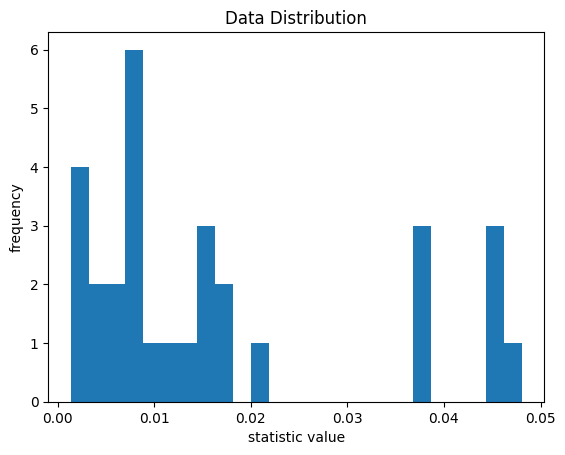

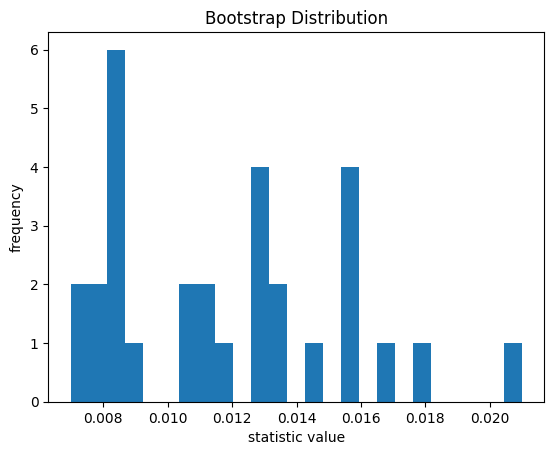

In [44]:

fig, ax = plt.subplots()
ax.hist(mnntr, bins=25)
ax.set_title('Data Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()


fig, ax = plt.subplots()
ax.hist(bs_1.bootstrap_distribution, bins=25)
ax.set_title('Bootstrap Distribution')
ax.set_xlabel('statistic value')
ax.set_ylabel('frequency')
plt.show()



In [11]:

columns_errors=['mae_nn_train','mae_nn_test','mae_mdl_train','mae_mdl_test','rmse_nn_train','rmse_nn_test','rmse_mdl_train','rmse_mdl_test']

#Mean values of 30 (3*10) simulations
mean_errors_df=errors_df.groupby(['sigma'],as_index=False)[columns_errors].mean()
display(mean_errors_df)


#Error
#1. For every sigma and every n, calculate means over the realizations
mean_n_over_r_df=errors_df.groupby(['n', 'sigma'],as_index=False)[columns_errors].mean()
#display(mean_n_over_r_df)

#2. Calculate stds over means of over realizations
std_n_over_r_df=mean_n_over_r_df.groupby(['sigma'],as_index=False)[columns_errors].std() 

#rename columns
std_n_over_r_df=std_n_over_r_df.rename(columns={column:'std_' + column for column in columns_errors})
display(std_n_over_r_df)


#3. sem: divide by sqare root of realizations
std_n_over_r_df[['sem_mae_nn_train','sem_mae_nn_test','sem_mae_mdl_train','sem_mae_mdl_test',\
                 'sem_rmse_nn_train','sem_rmse_nn_test','sem_rmse_mdl_train','sem_rmse_mdl_test' ]]=\
std_n_over_r_df[['std_mae_nn_train', 'std_mae_nn_test', 'std_mae_mdl_train', 'std_mae_mdl_test', 'std_rmse_nn_train',\
                 'std_rmse_nn_test','std_rmse_mdl_train','std_rmse_mdl_test' ]]/np.sqrt(realizations+1)

#sem_n_over_r_df=std_n_over_r_df[columns_errors]/np.sqrt(realizations+1)
display(std_n_over_r_df)

#rename columns
std_n_over_r_df=std_n_over_r_df.rename(columns={'mae_nn_train':  'std_mae_nn_train',  'mae_nn_test':  'std_mae_nn_test', 
                                            'mae_mdl_train': 'std_mae_mdl_train', 'mae_mdl_test': 'std_mae_mdl_test',
                                            'rmse_nn_train': 'std_rmse_nn_train', 'rmse_nn_test': 'std_rmse_nn_test' , 
                                            'rmse_mdl_train':'std_rmse_mdl_train','rmse_mdl_test':'std_rmse_mdl_test'})


errors_statistics_new=mean_errors_df.join(std_n_over_r_df.set_index('sigma'), on='sigma')
display(errors_statistics_new)

print('../data/errors_statistics_' + str(function) + '.csv')
errors_statistics_new.to_csv('../data/errors_statistics_' + str(function) + '.csv')

,sigma,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test,n,r
0,0.0,0.038346,0.031069,0.001119,9.678334e-03,0.048355,0.034498,0.001325,1.169205e-02,0,0
1,0.0,0.011996,0.106369,0.002785,3.321931e-01,0.015287,0.112211,0.003340,4.975634e-01,1,0
2,0.0,0.045330,0.568604,0.001012,5.818908e-02,0.119820,0.574555,0.001299,7.225381e-02,2,0
3,0.0,0.017690,0.168191,0.000309,4.174655e-02,0.043636,0.169878,0.000399,4.874519e-02,3,0
4,0.0,0.015367,0.066641,0.000170,2.948595e-03,0.019958,0.070403,0.000248,4.091270e-03,4,0
5,0.0,0.007376,0.071449,0.000487,1.408517e-01,0.012901,0.088791,0.000684,1.689972e-01,5,0
6,0.0,0.006577,0.091553,0.000324,1.811364e-02,0.016011,0.093125,0.000389,2.311304e-02,6,0
7,0.0,0.007777,0.060940,0.000700,2.582044e-02,0.014318,0.061244,0.000904,3.364340e-02,7,0
8,0.0,0.007191,0.098977,0.000051,5.952950e-02,0.015660,0.099978,0.000071,8.638921e-02,8,0
9,0.0,0.002033,0.026621,0.000014,2.454331e-01,0.002766,0.032740,0.000016,6.222422e-01,9,0


,sigma,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test
0,0.00,0.017055,0.131824,0.021218,inf,0.031831,0.137274,0.024321,inf
1,0.02,0.024488,0.126648,0.008538,1.225528e+01,0.040640,0.131665,0.011169,3.511932e+01
2,0.04,0.023552,0.106514,0.018165,7.247043e-02,0.032968,0.113084,0.022363,8.577097e-02
3,0.06,0.030517,0.196093,0.028401,1.818815e-01,0.043695,0.208920,0.035352,2.146793e-01
4,0.08,0.040236,0.118984,0.037672,2.752581e-01,0.054732,0.124087,0.046854,3.346801e-01
5,0.10,0.046230,0.224757,0.040629,1.984707e-01,0.067793,0.231479,0.052115,2.410020e-01
6,0.12,0.054552,0.200388,0.049357,5.161457e-01,0.076709,0.205137,0.061820,6.900875e-01
7,0.14,0.065086,0.144585,0.058810,3.253921e-01,0.089562,0.151999,0.076177,3.808002e-01
8,0.16,0.067557,0.297781,0.056738,1.959929e-01,0.093146,0.310959,0.068208,2.083971e-01
9,0.18,0.095329,0.320198,0.086780,3.808135e-01,0.129272,0.338743,0.108729,4.228715e-01


,sigma,std_mae_nn_train,std_mae_nn_test,std_mae_mdl_train,std_mae_mdl_test,std_rmse_nn_train,std_rmse_nn_test,std_rmse_mdl_train,std_rmse_mdl_test
0,0.00,0.014457,0.159525,0.064533,NaN,0.034257,0.159530,0.073746,NaN
1,0.02,0.014108,0.148175,0.003389,3.746248e+01,0.031014,0.148354,0.003853,1.093339e+02
2,0.04,0.008155,0.072339,0.008578,7.106072e-02,0.011646,0.075207,0.010452,8.500980e-02
3,0.06,0.011269,0.090048,0.010477,1.742007e-01,0.018556,0.091208,0.012600,2.126358e-01
4,0.08,0.011021,0.107482,0.023051,2.452125e-01,0.017751,0.106803,0.026800,3.096298e-01
5,0.10,0.018117,0.211769,0.016182,3.151474e-01,0.040227,0.212196,0.017479,3.970580e-01
6,0.12,0.017910,0.172630,0.021079,6.740252e-01,0.029505,0.171452,0.022637,1.040733e+00
7,0.14,0.014755,0.122688,0.030815,4.086417e-01,0.025473,0.124898,0.034630,5.074554e-01
8,0.16,0.029329,0.227187,0.037816,1.361117e-01,0.045209,0.227223,0.043924,1.403873e-01
9,0.18,0.019966,0.331683,0.033954,2.909062e-01,0.030116,0.341079,0.036757,3.267024e-01


,sigma,std_mae_nn_train,std_mae_nn_test,std_mae_mdl_train,std_mae_mdl_test,std_rmse_nn_train,std_rmse_nn_test,std_rmse_mdl_train,std_rmse_mdl_test,sem_mae_nn_train,sem_mae_nn_test,sem_mae_mdl_train,sem_mae_mdl_test,sem_rmse_nn_train,sem_rmse_nn_test,sem_rmse_mdl_train,sem_rmse_mdl_test
0,0.00,0.014457,0.159525,0.064533,NaN,0.034257,0.159530,0.073746,NaN,0.008347,0.092102,0.037258,NaN,0.019778,0.092105,0.042577,NaN
1,0.02,0.014108,0.148175,0.003389,3.746248e+01,0.031014,0.148354,0.003853,1.093339e+02,0.008145,0.085549,0.001957,2.162897e+01,0.017906,0.085652,0.002224,6.312393e+01
2,0.04,0.008155,0.072339,0.008578,7.106072e-02,0.011646,0.075207,0.010452,8.500980e-02,0.004708,0.041765,0.004952,4.102692e-02,0.006724,0.043421,0.006034,4.908043e-02
3,0.06,0.011269,0.090048,0.010477,1.742007e-01,0.018556,0.091208,0.012600,2.126358e-01,0.006506,0.051989,0.006049,1.005748e-01,0.010713,0.052659,0.007274,1.227654e-01
4,0.08,0.011021,0.107482,0.023051,2.452125e-01,0.017751,0.106803,0.026800,3.096298e-01,0.006363,0.062055,0.013308,1.415735e-01,0.010248,0.061663,0.015473,1.787648e-01
5,0.10,0.018117,0.211769,0.016182,3.151474e-01,0.040227,0.212196,0.017479,3.970580e-01,0.010460,0.122265,0.009343,1.819504e-01,0.023225,0.122511,0.010092,2.292415e-01
6,0.12,0.017910,0.172630,0.021079,6.740252e-01,0.029505,0.171452,0.022637,1.040733e+00,0.010341,0.099668,0.012170,3.891486e-01,0.017035,0.098988,0.013069,6.008675e-01
7,0.14,0.014755,0.122688,0.030815,4.086417e-01,0.025473,0.124898,0.034630,5.074554e-01,0.008519,0.070834,0.017791,2.359294e-01,0.014707,0.072110,0.019993,2.929795e-01
8,0.16,0.029329,0.227187,0.037816,1.361117e-01,0.045209,0.227223,0.043924,1.403873e-01,0.016933,0.131167,0.021833,7.858414e-02,0.026101,0.131187,0.025360,8.105267e-02
9,0.18,0.019966,0.331683,0.033954,2.909062e-01,0.030116,0.341079,0.036757,3.267024e-01,0.011527,0.191497,0.019603,1.679548e-01,0.017387,0.196922,0.021221,1.886217e-01


,sigma,mae_nn_train,mae_nn_test,mae_mdl_train,mae_mdl_test,rmse_nn_train,rmse_nn_test,rmse_mdl_train,rmse_mdl_test,std_mae_nn_train,...,std_rmse_mdl_train,std_rmse_mdl_test,sem_mae_nn_train,sem_mae_nn_test,sem_mae_mdl_train,sem_mae_mdl_test,sem_rmse_nn_train,sem_rmse_nn_test,sem_rmse_mdl_train,sem_rmse_mdl_test
0,0.00,0.017055,0.131824,0.021218,inf,0.031831,0.137274,0.024321,inf,0.014457,...,0.073746,NaN,0.008347,0.092102,0.037258,NaN,0.019778,0.092105,0.042577,NaN
1,0.02,0.024488,0.126648,0.008538,1.225528e+01,0.040640,0.131665,0.011169,3.511932e+01,0.014108,...,0.003853,1.093339e+02,0.008145,0.085549,0.001957,2.162897e+01,0.017906,0.085652,0.002224,6.312393e+01
2,0.04,0.023552,0.106514,0.018165,7.247043e-02,0.032968,0.113084,0.022363,8.577097e-02,0.008155,...,0.010452,8.500980e-02,0.004708,0.041765,0.004952,4.102692e-02,0.006724,0.043421,0.006034,4.908043e-02
3,0.06,0.030517,0.196093,0.028401,1.818815e-01,0.043695,0.208920,0.035352,2.146793e-01,0.011269,...,0.012600,2.126358e-01,0.006506,0.051989,0.006049,1.005748e-01,0.010713,0.052659,0.007274,1.227654e-01
4,0.08,0.040236,0.118984,0.037672,2.752581e-01,0.054732,0.124087,0.046854,3.346801e-01,0.011021,...,0.026800,3.096298e-01,0.006363,0.062055,0.013308,1.415735e-01,0.010248,0.061663,0.015473,1.787648e-01
5,0.10,0.046230,0.224757,0.040629,1.984707e-01,0.067793,0.231479,0.052115,2.410020e-01,0.018117,...,0.017479,3.970580e-01,0.010460,0.122265,0.009343,1.819504e-01,0.023225,0.122511,0.010092,2.292415e-01
6,0.12,0.054552,0.200388,0.049357,5.161457e-01,0.076709,0.205137,0.061820,6.900875e-01,0.017910,...,0.022637,1.040733e+00,0.010341,0.099668,0.012170,3.891486e-01,0.017035,0.098988,0.013069,6.008675e-01
7,0.14,0.065086,0.144585,0.058810,3.253921e-01,0.089562,0.151999,0.076177,3.808002e-01,0.014755,...,0.034630,5.074554e-01,0.008519,0.070834,0.017791,2.359294e-01,0.014707,0.072110,0.019993,2.929795e-01
8,0.16,0.067557,0.297781,0.056738,1.959929e-01,0.093146,0.310959,0.068208,2.083971e-01,0.029329,...,0.043924,1.403873e-01,0.016933,0.131167,0.021833,7.858414e-02,0.026101,0.131187,0.025360,8.105267e-02
9,0.18,0.095329,0.320198,0.086780,3.808135e-01,0.129272,0.338743,0.108729,4.228715e-01,0.019966,...,0.036757,3.267024e-01,0.011527,0.191497,0.019603,1.679548e-01,0.017387,0.196922,0.021221,1.886217e-01


../data/errors_statistics_tanh.csv


In [5]:
##INCOMPLETE!!

#Plot rmse
Extensions=['.png', '.pdf']

#Fonts and sizes                                                                                    
size_axis=7;size_ticks=6;size_title=5
line_w=1;marker_s=3 #width and marker size                                                          
m_size=6

#Define figure size in cm                                                                           
cm = 1/2.54 #convert inch to cm                                                                     
width = 8*cm; height=6*cm
rows=3;cols=10

width_panel = width*cols
height_panel= height*rows

fig=figure(figsize=(width_panel,height_panel), dpi=300)  
gs=gridspec.GridSpec(rows,cols)                                                                                                                         
gs.update(left=0.1,right=0.98,bottom=0.15,top=0.90,wspace=0.35,hspace=0.1) 

for row in range(len(rows)):
    print(row)
    for col in range(len(cols)): 
        print(col)

        ax_ij=plt.subplot(gs[i,j])
        plt.plot(dn['x1'], dn['ymodel'],linewidth=line_w, color='red', label='ann.  MSE_train= %.2E, MSE_test= %.2E' % ( MAE_nn_train, MAE_nn_test))

SyntaxError: incomplete input (2887671460.py, line 23)